In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/test.csv
/kaggle/input/rossmann-store-sales/train.csv


In [2]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import math
import sklearn.preprocessing as skpe
import sklearn.model_selection as ms
import sklearn.metrics as sklm
import sklearn.ensemble as sken
import sklearn.linear_model as lm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Reading files
path="../input/rossmann-store-sales/train.csv"
train=pd.read_csv(path)
print(train.shape)
train.head()

(1017209, 9)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
path1="../input/rossmann-store-sales/test.csv"
test=pd.read_csv(path1)
print(test.shape)
test.head()

(41088, 8)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
path2="../input/rossmann-store-sales/store.csv"
store_df=pd.read_csv(path2)
print(store_df.shape)
store_df.head()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train.info()
print("----------------------------------------------")

store_df.info()
print("----------------------------------------------")

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType      

**UNIVARIATE ANALYSIS**

In [7]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
# Adding new variable
train['Sales_per_customer']=train['Sales']/train['Customers']
train['Sales_per_customer'].describe() # An average of 9.49$ is earned from a customer at a particular store

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: Sales_per_customer, dtype: float64

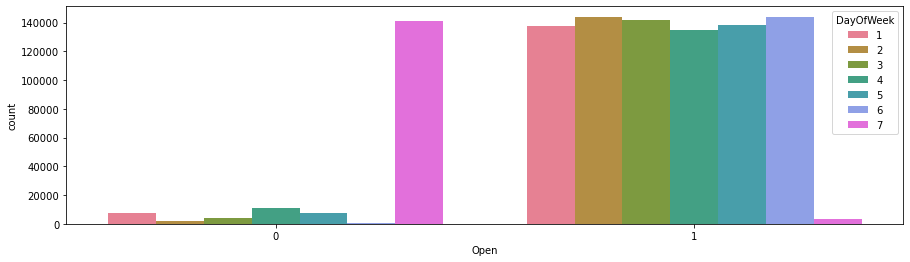

In [9]:
fig, ax1 = plt.subplots(figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=train,palette="husl", ax=ax1) # This indicates that there are some stores which opens mostly on Sundays while some are closed on Sundays 

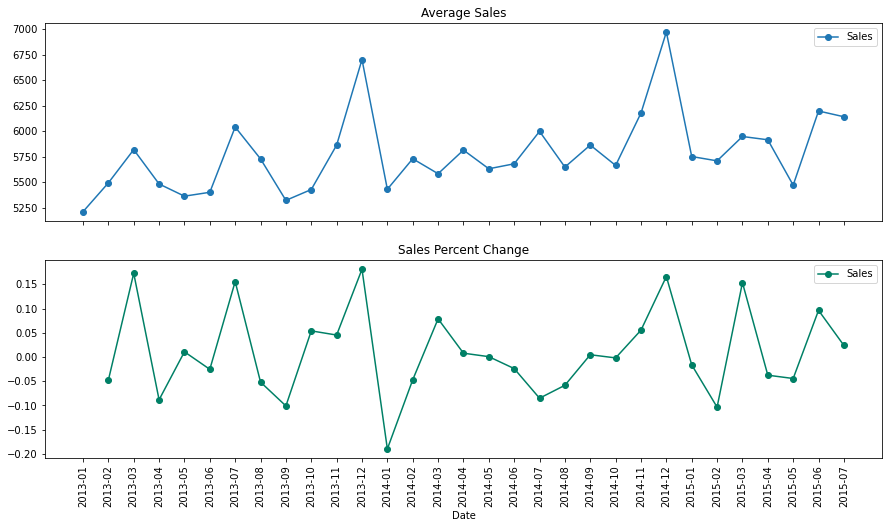

In [10]:
# Date

# Create Year and Month columns
train['Year']  = train['Date'].apply(lambda x: int(str(x)[:4]))
train['Month'] = train['Date'].apply(lambda x: int(str(x)[5:7]))

test['Year']  = test['Date'].apply(lambda x: int(str(x)[:4]))
test['Month'] = test['Date'].apply(lambda x: int(str(x)[5:7]))

# Assign Date column to Date(Year-Month) instead of (Year-Month-Day)
train['Date'] = train['Date'].apply(lambda x: (str(x)[:7]))
test['Date']     = test['Date'].apply(lambda x: (str(x)[:7]))

# group by date and get average sales, and percent change
avg_sales    = train.groupby('Date')["Sales"].mean()
pct_change_sales = train.groupby('Date')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = avg_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(avg_sales)))
ax1.set_xticklabels(avg_sales.index.tolist(), rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")

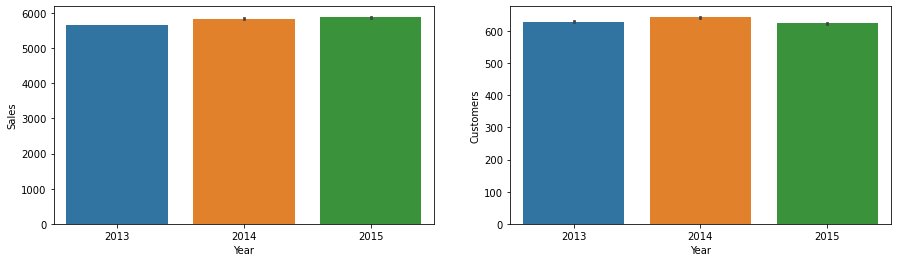

In [11]:
# Plot average sales and customers over years
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Year', y='Sales', data=train, ax=axis1)
sns.barplot(x='Year', y='Customers', data=train, ax=axis2)

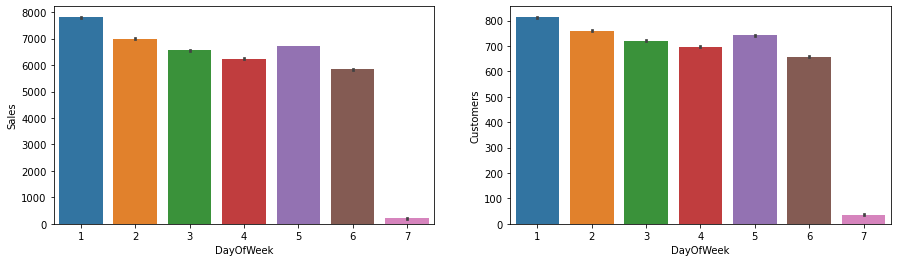

In [12]:
# Plot average sales and customers over days of week
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='Sales', data=train, ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=train, ax=axis2) 

Sales and Customers on Sunday are lowest

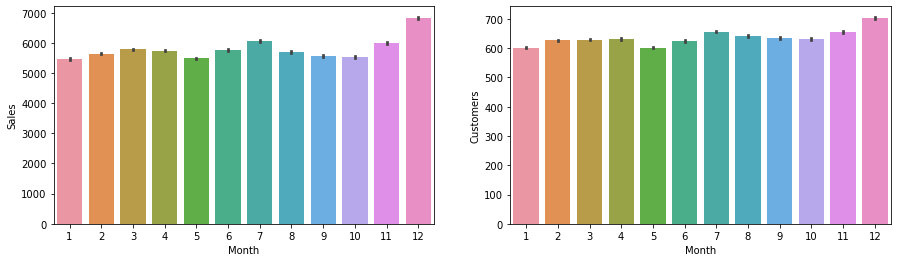

In [13]:
# Plot average sales and customers over months
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Month', y='Sales', data=train, ax=axis1)
sns.barplot(x='Month', y='Customers', data=train, ax=axis2)

Sales and Customers are comparatively higher in December as compared to other months

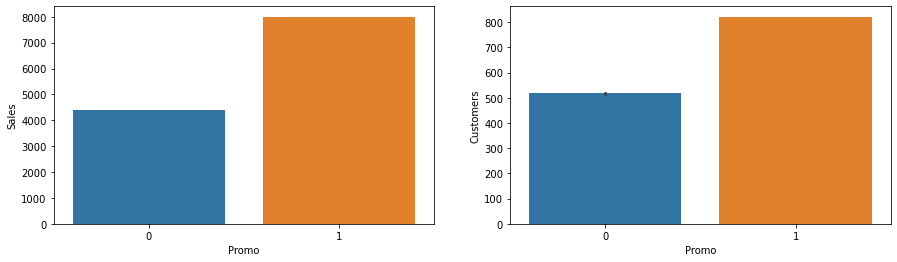

In [14]:
# Plot average sales and customers with/without promo
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo', y='Sales', data=train, ax=axis1)
sns.barplot(x='Promo', y='Customers', data=train, ax=axis2)

We can clearly see without promo the store doesn't stand a chance against stores with promo

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


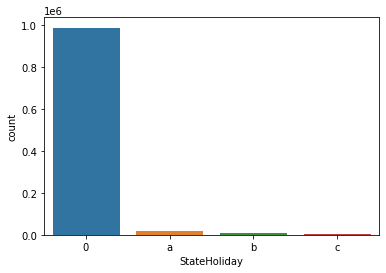

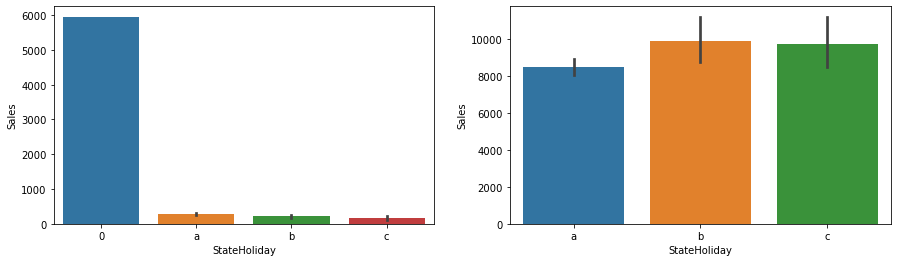

In [15]:
# StateHoliday has values 0 & "0", So, we need to merge values with 0 to "0"
train["StateHoliday"].loc[train["StateHoliday"] == 0] = "0"

sns.countplot(x='StateHoliday',data=train)

# Plot average sales on StateHoliday
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
filt = (train["StateHoliday"] != "0") & (train["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train[filt], ax=axis2)

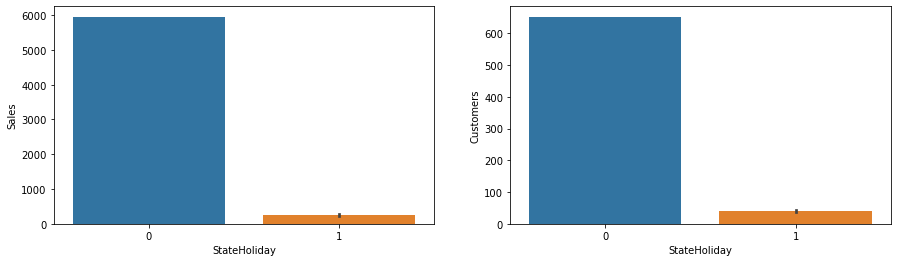

In [16]:
# Combining a,b and c type stores so as to reduce the bias
train["StateHoliday"] = train["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
test["StateHoliday"]     = test["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
sns.barplot(x='StateHoliday', y='Customers', data=train, ax=axis2)

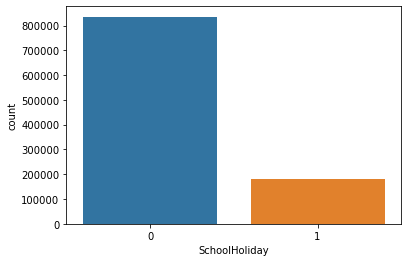

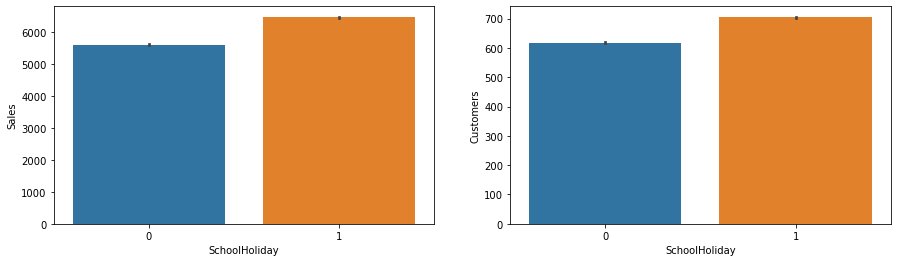

In [17]:
# Visualizing Sales over SchoolHoliday
sns.countplot(x='SchoolHoliday',data=train)

# Plot average sales on StateHoliday
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=train, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=train, ax=axis2)

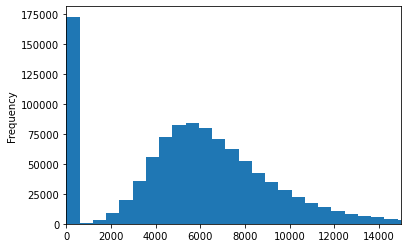

In [18]:
train["Sales"].plot(kind='hist',bins=70,xlim=(0,15000))

**There are mostly 0's in this plot because the store was closed**

In [19]:
store_df['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [20]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [21]:
# Merging train and store_df
train_store = pd.merge(right=store_df,left=train,how='outer',on='Store')
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales_per_customer,...,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07,5263,555,1,1,0,1,9.482883,...,7,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07,5020,546,1,1,0,1,9.194139,...,7,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07,4782,523,1,1,0,1,9.143403,...,7,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07,5011,560,1,1,0,1,8.948214,...,7,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07,6102,612,1,1,0,1,9.970588,...,7,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


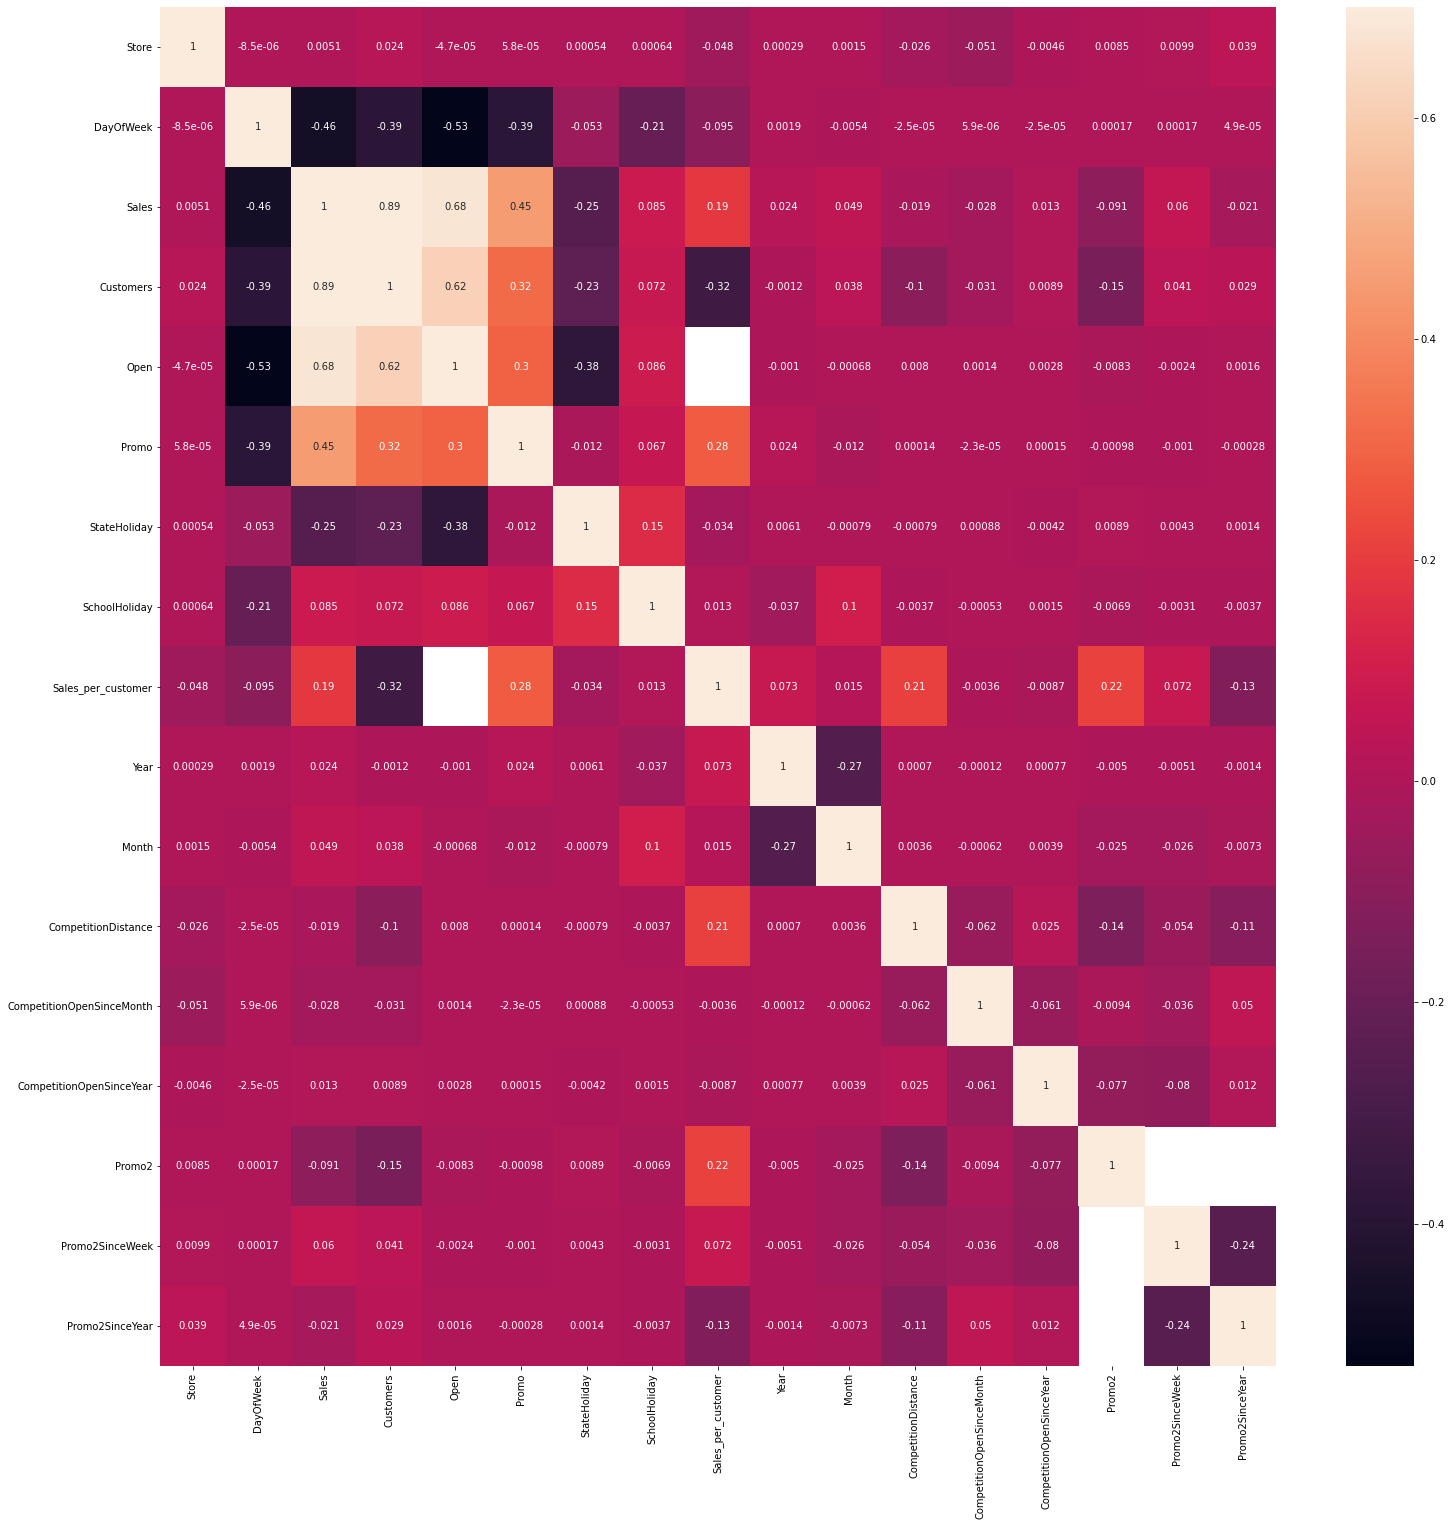

In [22]:
# Checking correlation bw different variables
plt.figure(figsize=(25,25))
sns.heatmap(train_store.corr(),vmax=.7,cbar=True,annot=True)

**The highly correlated features with the target variable(Sales) are :- Promo, Open, Customers, DayOfWeek**

**Treating Missing Values**

In [23]:
train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Sales_per_customer           172869
Year                              0
Month                             0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

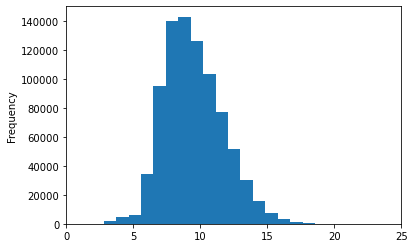

In [24]:
train_store["Sales_per_customer"].plot(kind='hist',bins=70,xlim=(0,25))

In [25]:
# Replacing missing values with median of their respective columns and dropping PromoInterval as it is not that much related to the dependent variable 

med_sales_per_customer = train_store['Sales_per_customer'].astype('float').median(axis=0)
train_store['Sales_per_customer'].replace(np.nan,med_sales_per_customer,inplace=True)

med_comp_dist = train_store['CompetitionDistance'].astype('float').median(axis=0)
train_store['CompetitionDistance'].replace(np.nan,math.floor(med_comp_dist),inplace=True)

med_comp_month = train_store['CompetitionOpenSinceMonth'].astype('float').median(axis=0)
train_store['CompetitionOpenSinceMonth'].replace(np.nan,math.floor(med_comp_month),inplace=True)

med_comp_year = train_store['CompetitionOpenSinceYear'].astype('float').median(axis=0)
train_store['CompetitionOpenSinceYear'].replace(np.nan,math.floor(med_comp_year),inplace=True)

med_promo2_week = train_store['Promo2SinceWeek'].astype('float').median(axis=0)
train_store['Promo2SinceWeek'].replace(np.nan,math.floor(med_promo2_week),inplace=True)

med_promo2_year = train_store['Promo2SinceYear'].astype('float').median(axis=0)
train_store['Promo2SinceYear'].replace(np.nan,math.floor(med_promo2_year),inplace=True)

train_store.drop(['PromoInterval'],axis=1,inplace=True)

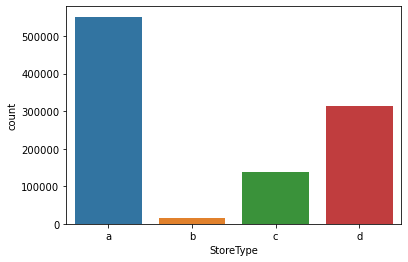

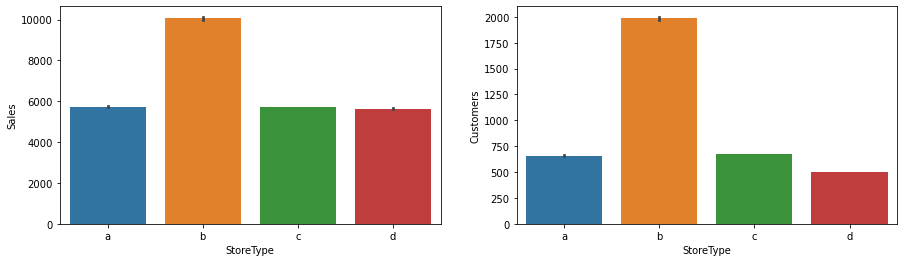

In [26]:
sns.countplot(x='StoreType', data=train_store, order=['a','b','c', 'd'])

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StoreType', y='Sales', data=train_store, order=['a','b','c', 'd'],ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=train_store, order=['a','b','c', 'd'], ax=axis2)

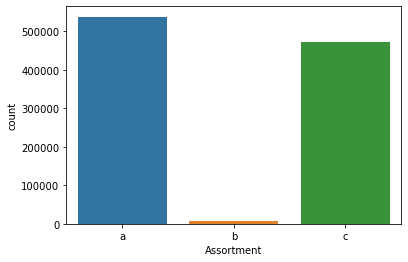

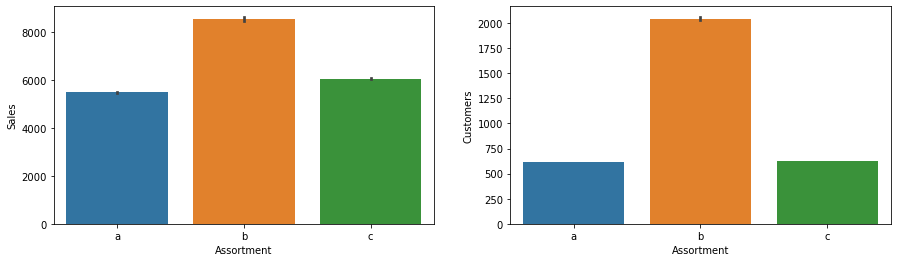

In [27]:
sns.countplot(x='Assortment', data=train_store, order=['a','b','c'])

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Assortment', y='Sales', data=train_store, order=['a','b','c'], ax=axis1)
sns.barplot(x='Assortment', y='Customers', data=train_store, order=['a','b','c'], ax=axis2)

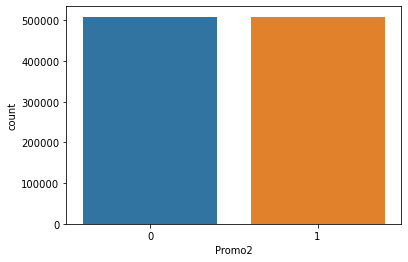

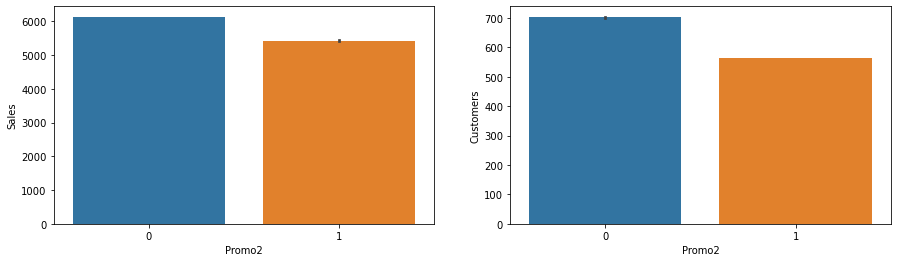

In [28]:
sns.countplot(x='Promo2', data=train_store)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo2', y='Sales', data=train_store, ax=axis1)
sns.barplot(x='Promo2', y='Customers', data=train_store, ax=axis2)

1.598650289950892

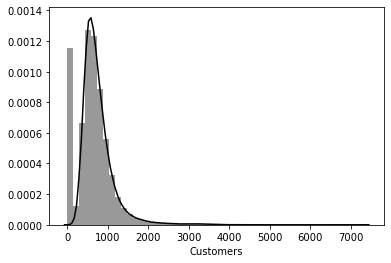

In [29]:
sns.distplot(train_store['Customers'],color='Black')
train_store['Customers'].skew()

0.6414596158103798

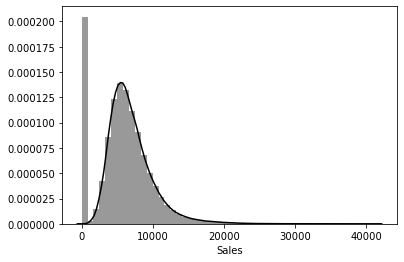

In [30]:
sns.distplot(train_store['Sales'],color='Black')
train_store['Sales'].skew()

**Droppin unnecessary columns from train and test set**

In [31]:
train.drop(['Customers','Sales_per_customer'],axis=1,inplace=True)
train['Open'] = train['Open'].astype(float)

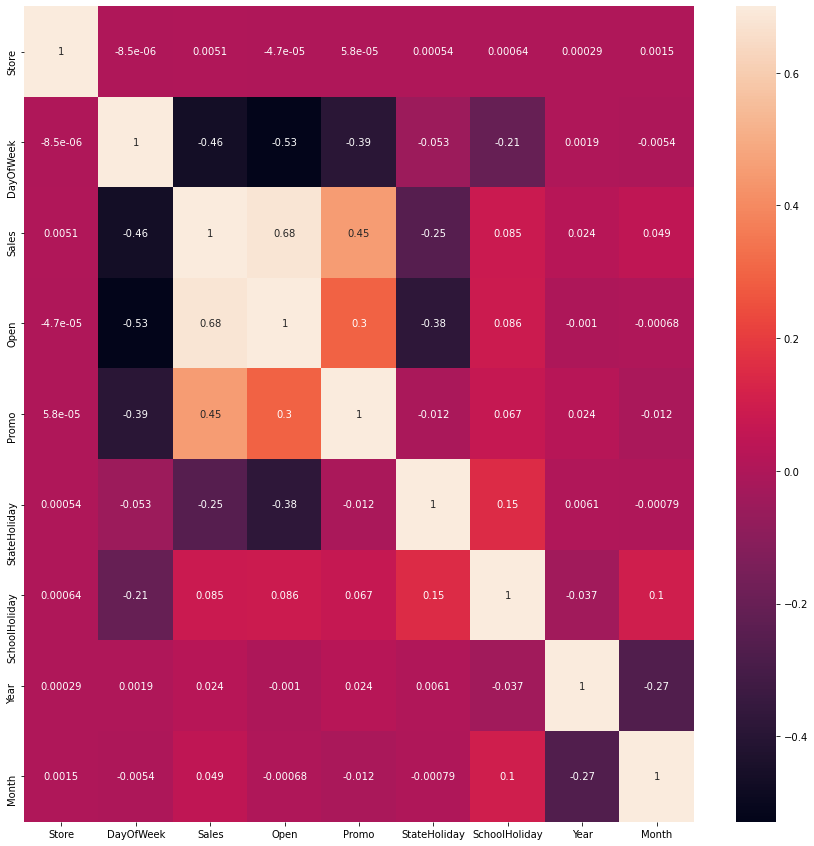

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(),vmax=.7,cbar=True,annot=True)

In [33]:
train.drop(['Year','Month','SchoolHoliday','Date'],axis=1,inplace=True)
test.drop(['Year','Month','SchoolHoliday','Date'],axis=1,inplace=True)

In [34]:
# Create dummy varibales for DayOfWeek
train_dummies  = pd.get_dummies(train['DayOfWeek'], prefix='Day')
train_dummies.drop(['Day_7'], axis=1, inplace=True)

test_dummies = pd.get_dummies(test['DayOfWeek'],prefix='Day')
test_dummies.drop(['Day_7'], axis=1, inplace=True)

train = train.join(train_dummies)
test = test.join(test_dummies)

In [35]:
# fill NaN values in test with Open=1 if DayOfWeek != 7
test["Open"][test["Open"] != test["Open"]] = (test["DayOfWeek"] != 7).astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
# Dropping DayOfWeek
train.drop(['DayOfWeek'], axis=1,inplace=True)
test.drop(['DayOfWeek'], axis=1,inplace=True)

# remove all rows(store,date) that were closed
train= train[train_store["Open"] != 0]

In [37]:
# Saving id's of those stores which were closed so we can put 0 in their respective sales column
closed_ids = test["Id"][test["Open"] == 0].values

In [38]:
# remove all rows(store,date) that were closed
test = test[test["Open"] != 0]

In [39]:
# Loop through each store, 
# train the model using the data of current store, and predict it's sales values.

train_dic = dict(list(train.groupby('Store')))
test_dic = dict(list(test.groupby('Store')))
submission = pd.Series()
scores = []

for i in test_dic:
    
    # current store
    store = train_dic[i]
    
    # define training and testing sets
    train_x = store.drop(["Sales","Store"],axis=1)
    train_y = store["Sales"]
    test_x = test_dic[i].copy()
    
    store_ids = test_x["Id"]
    test_x.drop(["Id","Store"], axis=1,inplace=True)
    
    # Linear Regression
    lr = lm.LinearRegression(normalize=True)
    lr.fit(train_x, train_y)
    pred_y = lr.predict(test_x)
    scores.append(lr.score(train_x, train_y))
    
    # append predicted values of current store to submission
    submission = submission.append(pd.Series(pred_y, index=store_ids))
    
# append rows(store,date) that were closed, and assign their sales value to 0
submission = submission.append(pd.Series(0, index=closed_ids))

# save to csv file
submission = pd.DataFrame({ "Id": submission.index, "Sales": submission.values})
submission.to_csv('rossmann.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
